In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load and prepare the data
data_file = 'Container_Dataset.xlsx'  
data = pd.ExcelFile(data_file)
df = data.parse('Sheet1')

df['DATE'] = pd.to_datetime(df['DATE'])
df['WEEK'] = df['DATE'].dt.isocalendar().week

df['YEAR'] = df['DATE'].dt.year

In [5]:
# Group data by week and calculate container count
weekly_data = df.groupby(['YEAR', 'WEEK', 'CONTAINER_LENGTH', 'CONTAINER_TYPE', 'VENTILATION', 'DESIGNATION']).size().reset_index(name='CONTAINER_COUNT')

# Prepare data for modeling
weekly_data_encoded = pd.get_dummies(weekly_data, columns=['CONTAINER_TYPE', 'VENTILATION', 'DESIGNATION'])
X = weekly_data_encoded.drop(columns=['YEAR', 'CONTAINER_COUNT']).values  
y = weekly_data_encoded['CONTAINER_COUNT'].values                         

In [7]:
# Scale the features for Linear Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Perform Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters from Grid Search: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [10]:
# K-Fold Cross-Validation for Random Forest and Linear Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Track cross-validated performance for Random Forest
rf_train_r2_scores = []
rf_test_r2_scores = []
rf_train_mse_scores = []
rf_test_mse_scores = []
rf_fold_details = []

# Track cross-validated performance for Linear Regression
lr_train_r2_scores = []
lr_test_r2_scores = []
lr_train_mse_scores = []
lr_test_mse_scores = []
lr_fold_details = []

for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Random Forest with Best Parameters
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_y_train_pred = rf_model.predict(X_train)
    rf_y_test_pred = rf_model.predict(X_test)
    rf_train_r2 = r2_score(y_train, rf_y_train_pred)
    rf_test_r2 = r2_score(y_test, rf_y_test_pred)
    rf_train_mse = mean_squared_error(y_train, rf_y_train_pred)
    rf_test_mse = mean_squared_error(y_test, rf_y_test_pred)

    rf_train_r2_scores.append(rf_train_r2)
    rf_test_r2_scores.append(rf_test_r2)
    rf_train_mse_scores.append(rf_train_mse)
    rf_test_mse_scores.append(rf_test_mse)
    rf_fold_details.append((fold, rf_train_r2, rf_test_r2, rf_train_mse, rf_test_mse))

    print(f"RF Fold {fold}: Train R²: {rf_train_r2:.4f}, Test R²: {rf_test_r2:.4f}, Train MSE: {rf_train_mse:.4f}, Test MSE: {rf_test_mse:.4f}")

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    lr_y_train_pred = lr_model.predict(X_train_scaled)
    lr_y_test_pred = lr_model.predict(X_test_scaled)
    lr_train_r2 = r2_score(y_train, lr_y_train_pred)
    lr_test_r2 = r2_score(y_test, lr_y_test_pred)
    lr_train_mse = mean_squared_error(y_train, lr_y_train_pred)
    lr_test_mse = mean_squared_error(y_test, lr_y_test_pred)

    lr_train_r2_scores.append(lr_train_r2)
    lr_test_r2_scores.append(lr_test_r2)
    lr_train_mse_scores.append(lr_train_mse)
    lr_test_mse_scores.append(lr_test_mse)
    lr_fold_details.append((fold, lr_train_r2, lr_test_r2, lr_train_mse, lr_test_mse))

    print(f"LR Fold {fold}: Train R²: {lr_train_r2:.4f}, Test R²: {lr_test_r2:.4f}, Train MSE: {lr_train_mse:.4f}, Test MSE: {lr_test_mse:.4f}")

# Create a DataFrame for metric summaries
metrics_summary = pd.DataFrame({
    "Model": ["Random Forest", "Linear Regression"],
    "Mean Train R-squared": [np.mean(rf_train_r2_scores), np.mean(lr_train_r2_scores)],
    "Mean Test R-squared": [np.mean(rf_test_r2_scores), np.mean(lr_test_r2_scores)],
    "Mean Train MSE": [np.mean(rf_train_mse_scores), np.mean(lr_train_mse_scores)],
    "Mean Test MSE": [np.mean(rf_test_mse_scores), np.mean(lr_test_mse_scores)]
})

RF Fold 1: Train R²: 0.9476, Test R²: 0.9440, Train MSE: 5.8564, Test MSE: 4.7336
LR Fold 1: Train R²: 0.6018, Test R²: 0.5730, Train MSE: 44.4770, Test MSE: 36.1067
RF Fold 2: Train R²: 0.9511, Test R²: 0.9054, Train MSE: 5.2392, Test MSE: 9.6857
LR Fold 2: Train R²: 0.5908, Test R²: 0.6266, Train MSE: 43.8743, Test MSE: 38.2409
RF Fold 3: Train R²: 0.9431, Test R²: 0.9399, Train MSE: 5.3054, Test MSE: 9.3903
LR Fold 3: Train R²: 0.5993, Test R²: 0.5828, Train MSE: 37.3584, Test MSE: 65.1761
RF Fold 4: Train R²: 0.9510, Test R²: 0.9213, Train MSE: 5.5233, Test MSE: 6.2457
LR Fold 4: Train R²: 0.6007, Test R²: 0.5457, Train MSE: 45.0137, Test MSE: 36.0709
RF Fold 5: Train R²: 0.9469, Test R²: 0.9336, Train MSE: 5.6416, Test MSE: 7.0380
LR Fold 5: Train R²: 0.5965, Test R²: 0.5724, Train MSE: 42.8688, Test MSE: 45.3496


In [13]:
# Display the summary
print(metrics_summary)

               Model  Mean Train R-squared  Mean Test R-squared  \
0      Random Forest              0.947942             0.928863   
1  Linear Regression              0.597827             0.580099   

   Mean Train MSE  Mean Test MSE  
0        5.513180       7.418639  
1       42.718444      44.188855  


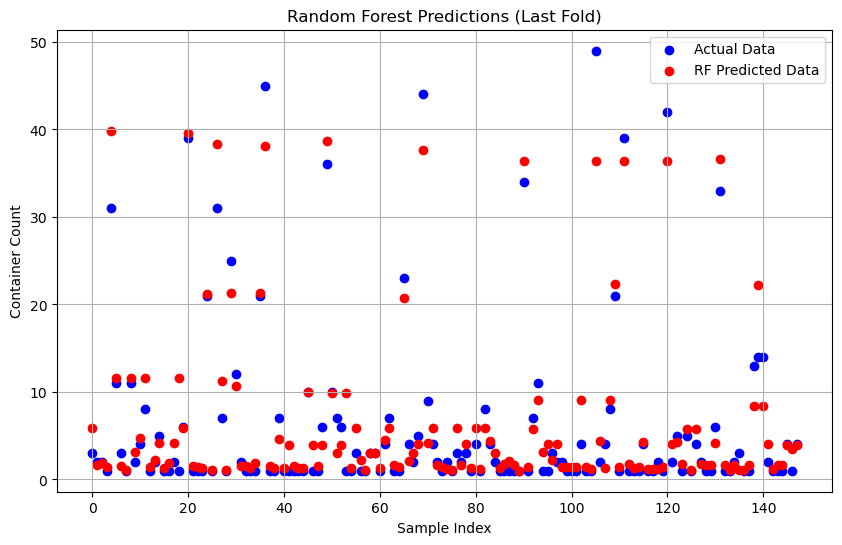

In [15]:
# Visualization for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Data')
plt.scatter(range(len(rf_y_test_pred)), rf_y_test_pred, color='red', label='RF Predicted Data')
plt.title('Random Forest Predictions (Last Fold)')
plt.xlabel('Sample Index')
plt.ylabel('Container Count')
plt.legend()
plt.grid()
plt.show()

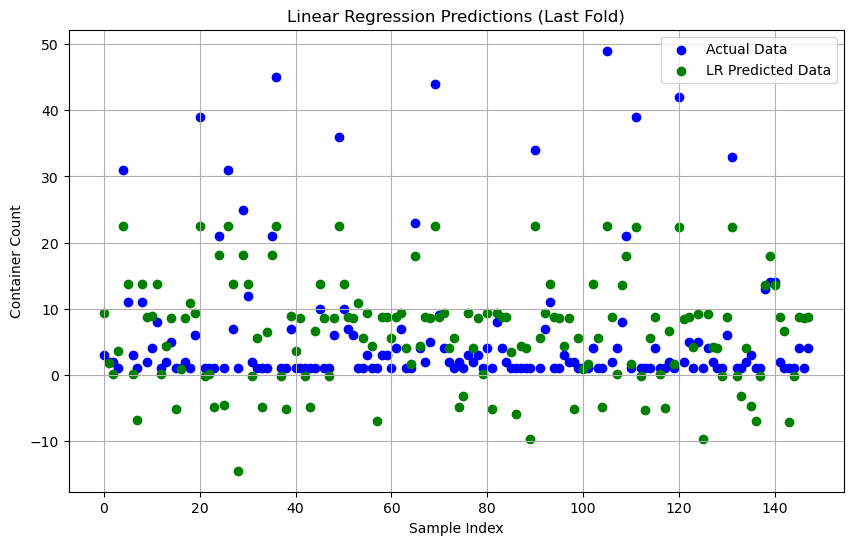

In [17]:
# Visualization for Linear Regression 
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Data')
plt.scatter(range(len(lr_y_test_pred)), lr_y_test_pred, color='green', label='LR Predicted Data')
plt.title('Linear Regression Predictions (Last Fold)')
plt.xlabel('Sample Index')
plt.ylabel('Container Count')
plt.legend()
plt.grid()
plt.show()

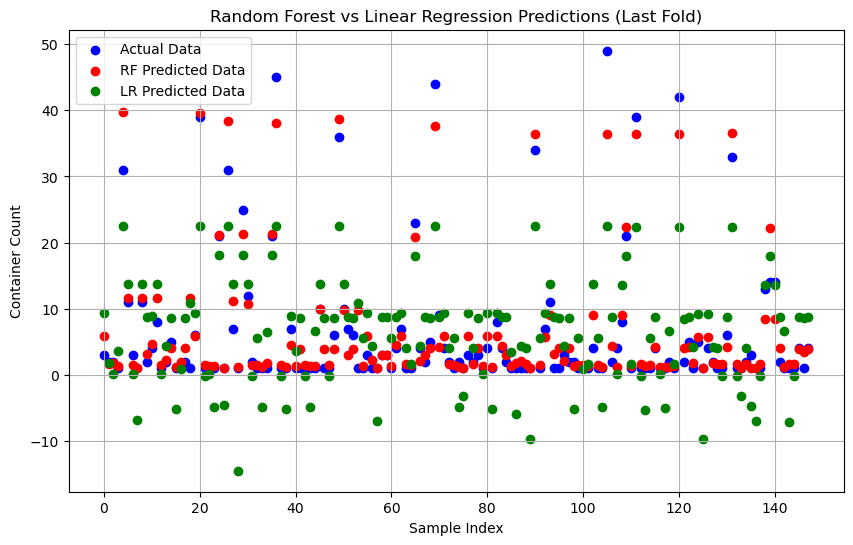

In [19]:
# Combined Visualization for the last fold
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Data')
plt.scatter(range(len(rf_y_test_pred)), rf_y_test_pred, color='red', label='RF Predicted Data')
plt.scatter(range(len(lr_y_test_pred)), lr_y_test_pred, color='green', label='LR Predicted Data')
plt.title('Random Forest vs Linear Regression Predictions (Last Fold)')
plt.xlabel('Sample Index')
plt.ylabel('Container Count')
plt.legend()
plt.grid()
plt.show()

In [21]:
# Small test set derived from the dataset
small_test_set = weekly_data_encoded.sample(3, random_state=57)  # Random sample of 3 rows from the dataset
small_test_features = small_test_set.drop(columns=['YEAR', 'CONTAINER_COUNT']).values
small_test_features_scaled = scaler.transform(small_test_features)

rf_small_test_predictions = rf_model.predict(small_test_features)
lr_small_test_predictions = lr_model.predict(small_test_features_scaled)

# Display predictions for the small test set
small_test_results = pd.DataFrame({
    "Week": small_test_set['WEEK'],
    "RF Predicted": rf_small_test_predictions,
    "LR Predicted": lr_small_test_predictions,
    "Actual": small_test_set['CONTAINER_COUNT']
})
print("\nSmall Test Set Predictions:")
print(small_test_results)


Small Test Set Predictions:
     Week  RF Predicted  LR Predicted  Actual
411    29      3.076394      8.652915       3
225    16      2.263359      4.371665       2
132    10      2.220635      4.496665       2
